In [1]:
#
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
from astropy.time import Time
#
import gsw
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)

In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
#
# parameters for the pre-processing step of CTD data sets
#

# data path
path_data = '../../data/'

# CTD Rosette infos: path and filename
path_CTD_data = path_data + 'CTD_Rosette/Polarstern/'
filename_CTD_data = path_CTD_data + 'PS122_*_Polarstern.txt'

# Polarstern trajectory infos: path and filename
path_track = path_data + 'TRACK/' 
filename_track = path_track + 'Polarstern_daily_track.nc'

# mesh infos: path and filename
path_mesh = path_data + 'MESH/'
filename_mesh = path_mesh + 'REcoM1D_daily_mesh_v2.nc'

# parameter related to the processing steps
# infos about interpolation and extrapolation of profile data (1st step of processing)
# linear or exponential convergence to freezing temperature or bottom temperature
temperature_extrapolation_high_depth_method = 'exponential' 
# width of the window for the moving average outlier removal (2nd step of processing)
window_width = 5

# output infos: path and filename
path_output = path_data + 'CTD_Rosette/'
filename_output = path_output + 'CTD_Polarstern_data.nc'
flag_smooth_output=True # flag whether to store smooth (moving averaged) salinity/temperature 2D fields or rough processed

In [3]:
files = gg(filename_CTD_data, recursive = True)
files = np.sort(files)

for i in np.arange(0,len(files)):
    print(files[i])
    df_temp = pd.read_csv(files[i], index_col = 'Date/Time', sep="\t", parse_dates=['Date/Time'])
    
    if i==0:
        df = df_temp
    else:
        df = pd.concat([df, df_temp])
        
#df = df.sort_index()

../../data/CTD_Rosette/Polarstern/PS122_1_Polarstern.txt
../../data/CTD_Rosette/Polarstern/PS122_2_Polarstern.txt
../../data/CTD_Rosette/Polarstern/PS122_3_Polarstern.txt
../../data/CTD_Rosette/Polarstern/PS122_4_Polarstern.txt


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../../data/CTD_Rosette/Polarstern/PS122_5_Polarstern.txt


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#
# load ITP data: dates, coordinates, depth, temperature, salinity
#

# compute depth from pressure using gsw librairy
def compute_depth(pressure, latitude):
    depth = []
    for press in pressure:
        tmp = gsw.z_from_p(press, latitude)
        depth.append(tmp)
    return np.asarray(depth)

# compute daily values of coordinates, temperature and salinity
def compute_daily_values(time, lon, lat, T, S, P):    
    # remove outliers
    ind=np.where(time>0)[0]
    time, lon, lat = time[ind], lon[ind], lat[ind]
    T, S = T[ind], S[ind]
    P = P[ind]
    
    # sort dates (daily)
    dates, indices = np.unique(np.floor(time), return_inverse=True)
    dates = dates
    
    # compute daily values
    longitude, latitude, temperature, salinity = np.nan*np.empty(shape=(len(dates)), dtype=int), np.nan*np.empty(shape=(len(dates)), dtype=int), np.nan*np.empty(shape=(5000,len(dates)), dtype=int), np.nan*np.empty(shape=(5000,len(dates)), dtype=int)
    
    for i in range(len(dates)):
            index = np.where(indices==i)[0]
            
            temp_tmp = T[index].values
            sal_tmp = S[index].values
            lon_tmp = lon[index].values
            lat_tmp = lat[index].values
            press_temp = P[index].values
            
            press_temp = np.asarray(press_temp, dtype=float)
            depths, index_depth = np.unique(np.floor(press_temp), return_inverse=True)
            
            tmp1 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp2 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp3 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp4 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            for j in range(len(depths)):
                ind = np.where(index_depth==j)[0]
                
                # longitude, latitude, temperature, salinity
                tmp1[j], tmp2[j] = np.nanmean(lon_tmp[ind]), np.nanmean(lat_tmp[ind])
                tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
            
            #plt.plot(tmp3)
            #plt.plot(tmp4)
            
            longitude[i] = np.nanmean(tmp1)
            latitude[i] = np.nanmean(tmp2)
            temperature[:len(tmp3),i] = tmp3
            salinity[:len(tmp4),i] = tmp4
            
    return dates, np.asarray(longitude), np.asarray(latitude), np.asarray(temperature), np.asarray(salinity)

# CTD Rosette data
class CTD_daily_data:
    def __init__(self,filename):
        self.estimate_daily_CTD_variables(filename)
        
    def estimate_daily_CTD_variables(self, filename):
        # 1. load CTD data
        files = gg(filename, recursive = True)
        for i in np.arange(0,len(files)):
            print(files[i])
            df_temp = pd.read_csv(files[i], index_col = 'Date/Time', sep="\t", parse_dates=['Date/Time'])
            if i==0:
                df = df_temp
            else:
                df = pd.concat([df, df_temp])

        #df = df.sort_index() 

        # dates (time axis)
        dates = df.index.to_julian_date()
        
        # coordinates
        longitude, latitude = df['Lon'], df['Lat']
        
        # salinity amd temperature
        salinity, temperature = df['practical Salinity PSU78 [ ]'], df['potential Temp. ref. pres. 0 dbar [°C]']
        
        # Pressure
        pressure = df['Pressure [dbar]']

        ## 2. compute daily values
        days, lon, lat, temp, sal = compute_daily_values(dates, longitude, latitude, temperature, salinity, pressure)
        print('daily values computed')
        
        ## 3. compute depth axis from pressureh
        depth = compute_depth(np.arange(1,5001), 85)
        print('Depth computed')
        
        ## 4. get Datetime dates back again
        
        def julian_to_datetime(jd):
            t = Time(float(jd), format='jd')
            gregorian_date = t.iso
            return pd.to_datetime(gregorian_date)

        datetime_dates = pd.Series(days).apply(julian_to_datetime)
        
        ## 5. store data with date convertion to matlab format
        self.dates, self.julian_dates, self.longitude, self.latitude = datetime_dates.values, days  - 1721421, lon, lat 
        self.depth, self.temperature, self.salinity = depth, temp.T, sal.T

# load data

CTD_data =  CTD_daily_data(filename_CTD_data)

../../data/CTD_Rosette/Polarstern/PS122_1_Polarstern.txt
../../data/CTD_Rosette/Polarstern/PS122_4_Polarstern.txt


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../../data/CTD_Rosette/Polarstern/PS122_3_Polarstern.txt
../../data/CTD_Rosette/Polarstern/PS122_5_Polarstern.txt


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../../data/CTD_Rosette/Polarstern/PS122_2_Polarstern.txt


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice


daily values computed
Depth computed


In [5]:
print(np.shape(CTD_data.temperature))
print(np.shape(CTD_data.salinity))

(86, 5000)
(86, 5000)


In [6]:
#
# load Polarstern daily trajectory 
#
class Trajectory_Polarstern:
    def __init__(self, filename):
        self.read_trajectory(filename)

    def read_trajectory(self, filename):
        ncid = Dataset(filename, "r", format="NETCDF4")
        self.dates = ncid['dates'][:]
        self.longitude, self.latitude = ncid['longitude'][:], ncid['latitude'][:]
        ncid.close()
#
# load MOSAiC trajectory
#
trajectory = Trajectory_Polarstern(filename_track)

In [7]:
#
# load daily mesh data
#
class mesh_data:
    def __init__(self, filename):
        self.read_vertical_mesh(filename)
        
    def read_vertical_mesh(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        
        # read vertical mesh
        self.nlevels, self.Z = ncid.variables['nlevels'][:]-1, ncid.variables['Z'][:]
        ncid.close()
#
# read mesh information
#
mesh = mesh_data(filename_mesh)

(86, 5000)
(86,)


/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/global/AWIsoft/intel-python/2020.2.902/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


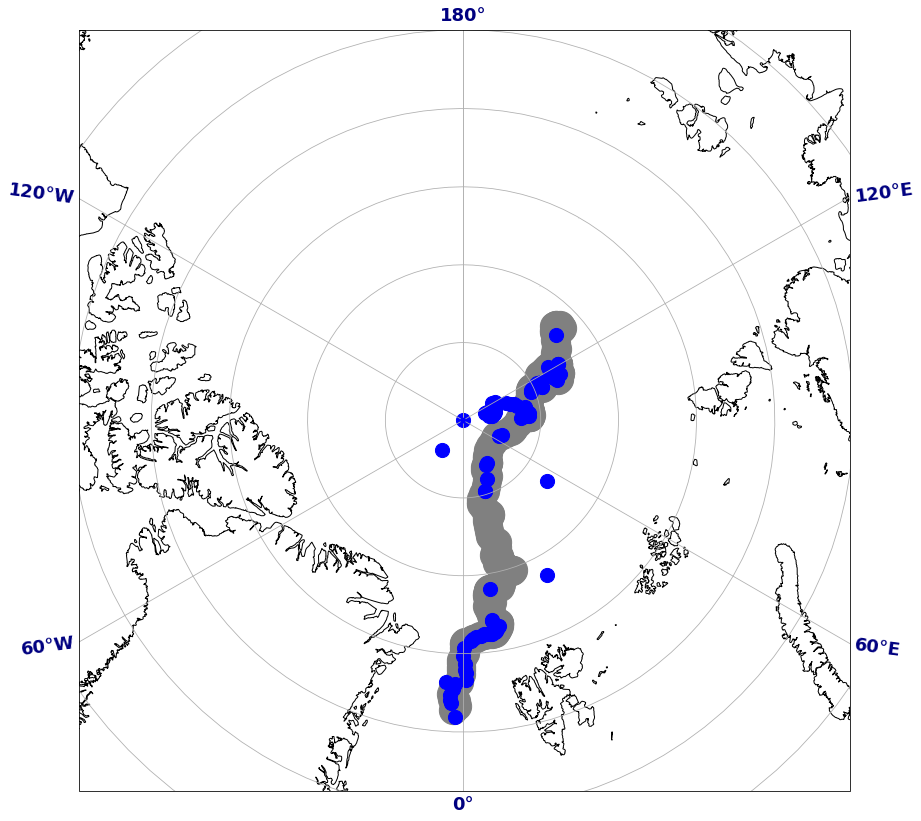

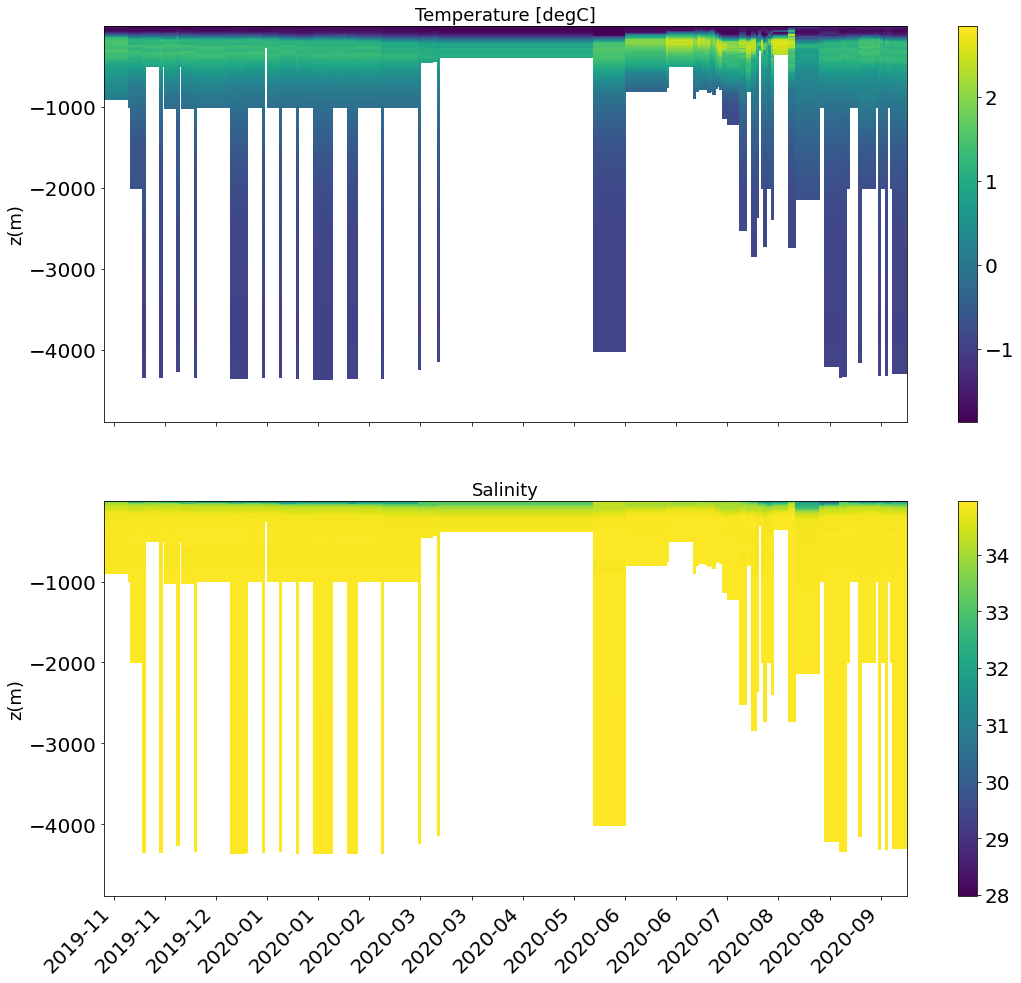

In [34]:
#
# Plot data for verification/visualization (track, 2D salinity/temperature)
#

# define Arctic map
def define_map():
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines(resolution='10m');
    #ax.stock_img()
    gl=ax.gridlines(draw_labels=True, dms=False)
    gl.xlabel_style = {'color': 'navy', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 0}
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    return(fig, ax)

# plot map
def plot_sensor_map(trajectory, data):
    Proj = ccrs.PlateCarree()
    fig, ax = define_map()
    plot_extent = [-180, 180, 75, 90]
    ax.set_extent(plot_extent, crs=Proj)
    lbsz, tcsz, mksz = 30, 20, 20
    rc('xtick', labelsize=tcsz) , rc('ytick', labelsize=tcsz)
    # trajectory of the Polarstern
    var=trajectory
    ax.scatter(var.longitude, var.latitude, c='0.5', s=800, transform=Proj)
    # trajectory of the sensor
    var=data
    ax.scatter(var.longitude, var.latitude, c='b', s=200, transform=Proj)
    
def plot_variables(data):
    date_ref = datetime.strptime('1970-01-01','%Y-%m-%d').toordinal()
    fsz, tl = (18,16), [np.min(mesh.dates)-date_ref, np.max(mesh.dates)-date_ref]
    
    temperature = data.temperature
    salinity = data.salinity
    
    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)
    # temperature
    print(np.shape(data.temperature))
    print(np.shape(data.julian_dates))
    
    Dstr, D, nt = np.zeros(temperature.shape).astype(str), np.zeros(temperature.shape), len(data.julian_dates)
    depths = np.zeros(data.temperature.shape)

    npd = data.temperature.shape[1]
    for i in range(npd):
            for j,dt in enumerate(data.julian_dates):
                D[j,i]= dt
                Dstr[j,i] = datetime.strftime(datetime.fromordinal(int(dt)), '%Y-%m-%d')

    npd = data.temperature.shape[0]
    for i in range(npd):
            for j,dt in enumerate(data.depth):
                depths[i,j]= dt

    dates = D - date_ref
    dates[dates<=0] = np.nan
    
    p1 = ax[0].pcolor(dates, depths, temperature)
    ax[0].axvline(x=737587)
    ax[0].set_xlim(tl)
    ax[0].set_ylabel('z(m)', fontsize=18)
    ax[0].set_title('Temperature [degC]', fontsize=18)
    
    # salinity
    p2 = ax[1].pcolor(dates, depths, salinity)
    ax[1].set_xlim(tl)
    ax[1].set_ylabel('z(m)', fontsize=18)
    ax[1].set_title('Salinity', fontsize=18)
    
    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[1].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    
    cb1 = fig.colorbar(p1, ax=ax[0])
    cb2 = fig.colorbar(p2, ax=ax[1])
    
    plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
    
    np.savez('CTD_Polarstern_raw.npz', dates = dates, depths = depths, 
         temperature = temperature, salinity = salinity, allow_pickle=True)
    
def plot_sensor_data(trajectory, data):
    # plot drift map
    plot_sensor_map(trajectory, data)
    
    # plot temperature and salinity
    plot_variables(data)
#
#
# plot sensor trajectory and salinity/temperature raw signal
plot_sensor_data(trajectory, CTD_data)

In [55]:
# compute daily values of coordinates, temperature and salinity
def compute_daily_values(time, lon, lat, T, S, P):    
    # remove outliers
    ind=np.where(time>0)[0]
    time, lon, lat = time[ind], lon[ind], lat[ind]
    T, S = T[ind], S[ind]
    P = P[ind]
    
    # sort dates (daily)
    dates, indices = np.unique(np.floor(time), return_inverse=True)
        
    # compute daily values
    longitude, latitude, temperature, salinity = np.nan*np.empty(shape=(len(dates)), dtype=int), np.nan*np.empty(shape=(len(dates)), dtype=int), np.nan*np.empty(shape=(5000,len(dates)), dtype=int), np.nan*np.empty(shape=(5000,len(dates)), dtype=int)
    
    for i in range(len(dates)):
            index = np.where(indices==i)[0]
            
            temp_tmp = T[index].values
            sal_tmp = S[index].values
            lon_tmp = lon[index].values
            lat_tmp = lat[index].values
            press_temp = P[index].values
            
            press_temp = np.asarray(press_temp, dtype=float)
            depths, index_depth = np.unique(np.floor(press_temp), return_inverse=True)
            
            tmp1 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp2 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp3 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            tmp4 = np.empty(shape = (len(depths)), dtype = int) * np.nan
            for j in range(len(depths)):
                ind = np.where(index_depth==j)[0]
                
                # longitude, latitude, temperature, salinity
                tmp1[j], tmp2[j] = np.nanmean(lon_tmp[ind]), np.nanmean(lat_tmp[ind])
                tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
            
            plt.plot(tmp3)
            plt.plot(tmp4)
            
            longitude[i] = np.nanmean(tmp1)
            latitude[i] = np.nanmean(tmp2)
            temperature[:len(tmp3),i] = tmp3
            salinity[:len(tmp4),i] = tmp4
            
    return dates, np.asarray(longitude), np.asarray(latitude), np.asarray(temperature), np.asarray(salinity)

/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/1626490242.py:36: RuntimeWarning: Mean of empty slice
  tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/1626490242.py:36: RuntimeWarning: Mean of empty slice
  tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/1626490242.py:36: RuntimeWarning: Mean of empty slice
  tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/1626490242.py:36: RuntimeWarning: Mean of empty slice
  tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])
/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/1626490242.py:36: RuntimeWarning: Mean of empty slice
  tmp3[j], tmp4[j] = np.nanmean(temp_tmp[ind]), np.nanmean(sal_tmp[ind])


daily values computed


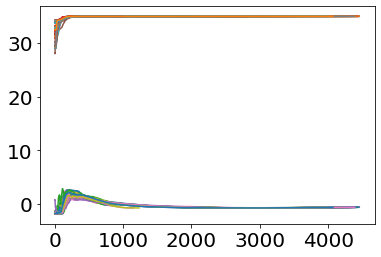

In [56]:
# dates (time axis)
dates = df.index.to_julian_date()
        
# coordinates
longitude, latitude = df['Lon'], df['Lat']
        
# salinity amd temperature
salinity, temperature = df['practical Salinity PSU78 [ ]'], df['in-situ temperature ITS-90 [°C]']

# Pressure

pressure = df['Pressure [dbar]']

## 2. compute daily values
days, lon, lat, temp, sal = compute_daily_values(dates, longitude, latitude, temperature, salinity, pressure)
print('daily values computed')

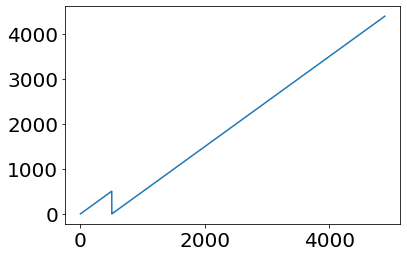

In [273]:
plt.plot(press_temp)

In [285]:
np.shape(temp)

(5000, 86)

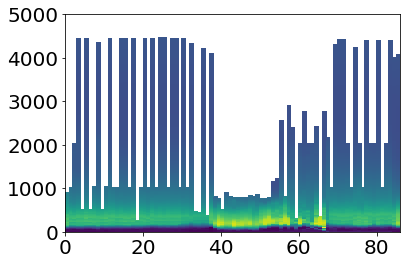

In [286]:
plt.pcolor(temp)

In [57]:
np.nanmean((temp[4000:,:]),axis=0)

/var/folders/1x/nxv9p5b51yv4883j8qsyv7h87pqqd6/T/ipykernel_11873/3564467072.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean((temp[4000:,:]),axis=0)


array([        nan,         nan,         nan, -0.64686507,         nan,
       -0.64727941,         nan,         nan, -0.65068017,         nan,
               nan, -0.6468129 ,         nan,         nan, -0.64608603,
       -0.64739434,         nan, -0.64679841,         nan,         nan,
       -0.64733793,         nan, -0.64555234,         nan, -0.64593319,
       -0.6461131 ,         nan, -0.64592049, -0.64553104,         nan,
       -0.64618842,         nan, -0.65171871,         nan,         nan,
       -0.65650089,         nan, -0.65548235,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.65

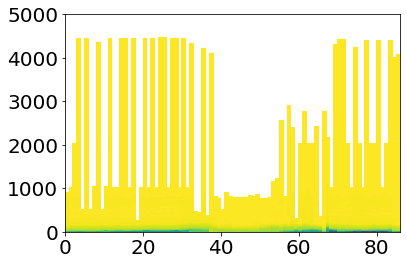

In [58]:
plt.pcolor(sal)

In [59]:
np.shape(sal)

(5000, 86)

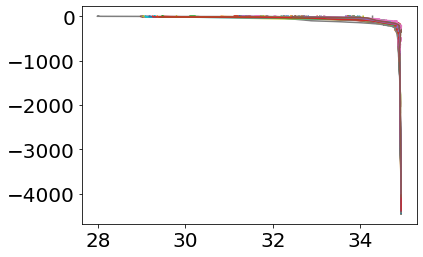

In [63]:
for i in np.arange(86):
    plt.plot(sal[:,i], -np.arange(0,5000))

In [64]:
sal[700,i]

34.906

In [65]:
sal[4000,i]

34.9389